In [14]:
import math
import types
import warnings
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from Genetic import Genome
from Genetic import Problem
from Genetic import Genetic

In [15]:
class Gene:
    replace = 0.1
    def __init__(self, input=0, output=10, weight=1.0):
        self.input=input
        self.output=output
        self.weight=weight
        self.enabled=True
    def copy(self):
        g = Gene(self.input, self.output, self.weight)
        g.enabled = self.enabled
        return g
    def disable(self):
        self.enabled = False
    def enable(self):
        self.enabled = True
    def mutate(self):
        if random.random() < Gene.replace:
            self.weight = random.normalvariate()
            return
        self.weight += random.normalvariate()*0.3
    def __str__(self):
        st = "{in: " + str(self.input) + ", out: " + str(self.output) + ", weight: " + str(self.weight) + ", enabled: " + str(self.enabled) + "}"
        return st

In [16]:
class Node:
    def __init__(self, num=0, activation = None):
        self.activation = activation
        self.num = num
def sigmoid(x):
    return 1/(1+math.exp(-4.9*x))
class Network:
    def __init__(self, N, M):
        self.N = N
        self.M = M
        self.network = dict()
        self.order = []
        self.layers = []
    def create(self, allgenes):
        genes = {}
        for k in allgenes:
            if allgenes[k].enabled:
                genes[k] = allgenes[k]
        numNeeded = len(set([b for (a, b) in genes]))
        for (a, b) in genes:
            if b not in self.network:
                self.network[b] = []
            self.network[b].append((a, genes[(a, b)].weight)) 
        s = set()
        self.layers.append([])
        for i in range(self.N):
            s.add(i)
            self.layers[0].append(i)
        while(len(self.order) < numNeeded-self.M):
            cands = set([b for (a, b) in genes if a in s and b not in s and b >= self.N+self.M])
            cands = [c for c in cands if len([a for (a, w) in self.network[c] if a not in s]) == 0]
            self.layers.append([])
            for c in cands:
                self.order.append(c)
                s.add(c)
                self.layers[-1].append(c)
        self.layers.append([])
        for i in range(self.N, self.N+self.M):
            self.order.append(i)
            self.layers[-1].append(i)
    def print(self):
        print(self.order)
        print(self.network)
    def calculate(self, inputs):
        inputs.append(1.0)
        values = {}
        for i in range(self.N):
            values[i] = inputs[i]
        for i in self.order:
            values[i] = 0.0
        for i in self.order:
            for a, w in self.network[i]:
                values[i] += values[a]*w
            values[i] = sigmoid(values[i])
        return [values[i] for i in range(self.N, self.N+self.M)]
    def drawNode(x, y, num, ax):
        text = str(num)
        box = ax.text(x, y, text, ha="center", va="center", fontsize=18)
        circle = Circle((x, y), 0.03, facecolor="skyblue", edgecolor="black", zorder=2)
        ax.add_patch(circle)
    def draw(self):
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot()
        radius = 0.03

        centers = dict()
        L = len(self.layers)
        g = (1.0-2*L*radius)/(L+1)
        g += 2*radius
        X = g-radius
        for i in range(len(self.layers)):
            L = len(self.layers[i])
            gy = (1.0-2*L*radius)/(L+1)
            gy += 2*radius
            Y = gy-radius
            for e in range(len(self.layers[i])-1, -1, -1):
                centers[self.layers[i][e]] = (X, Y)
                Y += gy
            X += g
        for i in range(self.N):
            Network.drawNode(centers[i][0], centers[i][1], i, ax)
        for i in self.order:
            Network.drawNode(centers[i][0], centers[i][1], i, ax)
        for e in self.order:
            for i,w in self.network[e]:
                X1, Y1 = centers[i]
                X2, Y2 = centers[e]
                color = "blue"
                if w < 0.0:
                    color = "red"
                ax.plot([X1, X2], [Y1, Y2], color=color, zorder=1)
        
        
        

In [17]:
class NEATGenome(Genome):
    addNodeProb = 0.05
    addConnectionProb = 0.15
    reEnableConnectionProb = 0.05
    mutateEdgeProb = 0.05
    split = {}
    nodeNum = 0
    N = 0
    M = 0
    prob = None
    speciationC1 = 0.5
    speciationC2 = 0.5
    innovationNumber = {}
    #deleteNodeProb = 0.05
    #deleteConnectionProb = 0.05
    def config(NN, MM, pp, anp = 0.03, acp = 0.05, recp = 0.25, mep = 0.8, c1 = 1.0, c2 = 1.0, c3 = 0.4):
        NEATGenome.N = NN+1
        NEATGenome.M = MM
        NEATGenome.prob = pp
        NEATGenome.nodeNum = NN+MM+1
        NEATGenome.addNodeProb = acp
        NEATGenome.addConnectionProb = acp
        NEATGenome.reEnableConnectionProb = recp
        NEATGenome.mutateEdgeProb = mep
        NEATGenome.speciationC1 = c1
        NEATGenome.speciationC2 = c2
        NEATGenome.speciationC3 = c3
        NEATGenome.innovationNumber = {}
        NEATGenome.split = {}
    def pathFrom(self, a, b):
        def allBefore(v, vis):
            res = set()
            for (x, y) in self.genes:
                if y == v:
                    if x not in vis:
                        vis.add(x)
                        allBefore(x, vis)
        S = set()
        allBefore(b, S)
        return (a in S)

    def __init__(self, prob=None):
        super().__init__(prob)
        self.nodes = {}
        self.genes = {}
    def initialize(self):
        for i in range(NEATGenome.N+NEATGenome.M):
            self.nodes[i] = Node(i)
        for i in range(NEATGenome.N):
            for e in range(NEATGenome.N, NEATGenome.N+NEATGenome.M):
                self.addConnection(i, e, random.normalvariate())
    def createStructure(self, layers):
        for i in range(layers[0]):
            self.nodes[i] = Node(i)
        nums = [list(range(layers[0]))]
        nxt = layers[0]+layers[-1]
        for i in range(1, len(layers)-1):
            nums.append(list(range(nxt, nxt+layers[i])))
            nxt += layers[i]
        nums.append(list(range(layers[0], layers[0]+layers[-1])))
        for i in range(1, len(layers)):
            for v2 in nums[i]:
                self.nodes[v2] = Node(v2)
                for v1 in nums[i-1]:
                    self.addConnection(v1, v2, random.normalvariate())
        for i in range(2, len(layers)):
            for v in nums[i]:
                self.addConnection(layers[0]-1, v, random.normalvariate())
        
    def cross(self, gen2):
        assert(self.checkCycles() and gen2.checkCycles())
        res = NEATGenome(self.prob)
        for a in self.genes:
            if a in gen2.genes and random.random() < 0.5:
                res.genes[a] = gen2.genes[a].copy()
            else:
                res.genes[a] = self.genes[a].copy()
            res.genes[a].enabled = self.genes[a].enabled
        for a in self.nodes:
            res.nodes[a] = self.nodes[a]
        for a in res.genes:
            if not res.genes[a].enabled and random.random() < NEATGenome.reEnableConnectionProb:
                res.genes[a].enable()
        if not res.checkCycles():
            print(self.checkCycles(), gen2.checkCycles())
            assert(False)
        return res
    def checkCycles(self):
        a = set([a for (a, b) in self.genes] + [b for (a, b) in self.genes])
        for i in a:
            for e in a:
                if i == e: continue
                if self.pathFrom(i, e) and self.pathFrom(e, i):
                    return False
        return True
    def mutate(self):
        if random.random() < NEATGenome.addNodeProb:
            #print("here")
            key = random.choice(list(self.genes.keys()))
            while key[0] == self.N-1 or not self.genes[key].enabled:
                key = random.choice(list(self.genes.keys()))
            self.splitConnection(key)
        if random.random() < NEATGenome.addConnectionProb:
            b = random.choice(list(self.nodes.keys()))
            while b >= NEATGenome.N-1 and b < NEATGenome.N+NEATGenome.M:
                b = random.choice(list(self.nodes.keys()))
            e = random.choice(list(self.nodes.keys()))
            while e < NEATGenome.N:
                e = random.choice(list(self.nodes.keys()))
            if ((b, e) not in self.genes) and (b != e) and not (self.pathFrom(e, b)):
                self.addConnection(b, e, random.random())
        if random.random() < NEATGenome.mutateEdgeProb:
            for g in self.genes.values(): 
                if g.enabled: g.mutate()
        self.validate()
    def splitConnection(self, key):
        node = Node(NEATGenome.nodeNum)
        if key in NEATGenome.split:
            node.num = NEATGenome.split[key]
        else:
            NEATGenome.split[key] = node.num
            NEATGenome.nodeNum += 1
            print(NEATGenome.nodeNum)
        self.nodes[node.num] = node
        num = node.num
        self.addConnection(key[0], num, 1.0)
        self.addConnection(num, key[1], self.genes[key].weight)
        self.genes[key].disable()
        if key[0] != self.N-1:
            self.addConnection(self.N-1, num, 0.0)
    def validate(self):
        if not self.checkCycles():
            self.print()
            assert False, "Cycle found in graph"
        for key in self.genes:
            if key[0] >= NEATGenome.nodeNum or key[1] >= NEATGenome.nodeNum:
                print(NEATGenome.nodeNum)
                self.print()
                assert False, "Node num not counted correctly"
    def addConnection(self, a, b, w):
        if a == b:
            self.print()
            print(NEATGenome.nodeNum)
            print(a, b, w)
            assert(False)
        if (a, b) not in NEATGenome.innovationNumber:
            l = len(NEATGenome.innovationNumber)
            NEATGenome.innovationNumber[(a, b)] = l
        self.genes[(a, b)] = Gene(a, b, w)
    def speciationLikeness(self, gene2):
        mn = max([NEATGenome.innovationNumber[a] for a in self.genes]+[NEATGenome.innovationNumber[a] for a in gene2.genes])
        E = 0
        D = 0
        C = 0
        W = 0.0
        N = max(len(self.genes), len(gene2.genes))
        for i in self.genes:
            if i not in gene2.genes:
                if NEATGenome.innovationNumber[i] <= mn:
                    D+=1
                else:
                    E+=1
        for i in gene2.genes:
            if i not in self.genes:
                if NEATGenome.innovationNumber[i] <= mn:
                    D+=1
                else:
                    E+=1
        for i in self.genes:
            if i in gene2.genes:
                C += 1
                W += abs(self.genes[i].weight - gene2.genes[i].weight)
        return (NEATGenome.speciationC3*W/(C) + NEATGenome.speciationC1*E/N + NEATGenome.speciationC2*D/N)
    def print(self):
        for g in self.genes:
            print(NEATGenome.innovationNumber[g], self.genes[g])
    def getNetwork(self):
        #self.print()
        nn = Network(NEATGenome.N, NEATGenome.M)
        nn.create(self.genes)
        return nn
    def testFitness(self):
        nn = self.getNetwork()
        self.fitness = self.prob.getScore(nn)
        return self.fitness
    
            
        

In [18]:
class NEATGenetic(Genetic):
    compatabilityThreshold = 3.0
    def speciesNextGenerationOld(self, species, speciesSize, carry):
        carry = min(carry, len(species))
        if(len(species) == 1):
            species.append(species[0].cross(species[0]))
            species[1].mutate()
            return species
        if carry >= len(species):
            for i in range(len(species)//2):
                species[i].mutate()
            return species
        if carry >= speciesSize:
            return species[-carry:]
        next = []
        while len(next) < (speciesSize-carry):
            pw = [0]*(carry-speciesSize) + list(range(1, 1+carry))
            g1 = Genetic.selectRandomWeighted(species, [0]*(carry-speciesSize) + list(range(1, 1+carry)))
            pw = range(1, 1+len(species))
            g2 = Genetic.selectRandomWeighted(species, [0]*(carry-speciesSize) + list(range(1, 1+carry)))
            while g2 == g1:
                g2 = Genetic.selectRandomWeighted(species, [0]*(carry-speciesSize) + list(range(1, 1+carry)))
            if g2.fitness > g1.fitness:
                g1, g2 = g2, g1
            o1 = g1.cross(g2)
            o1.mutate()
            next.append(o1)
        while len(next) > speciesSize-carry:
            next.pop(speciesSize-carry)
        for i in range(carry):
            next.append(species[len(species)-1-i])
        return next
    def nextGenerationOld(self):
        species = []
        for org in self.population:
            ind = 0
            while ind < len(species):
                if species[ind][0].speciationLikeness(org) < NEATGenetic.compatabilityThreshold:
                    species[ind].append(org)
                    break
                ind += 1
            if ind == len(species): species.append([org])
        for s in species:
            for o in s:
                o.fitness /= len(s)
        print([len(s) for s in species])
        pop = [sum(o.fitness for o in s) for s in species]
        S = sum(pop)
        for i in range(len(pop)):
            pop[i] = int(pop[i]*self.popSize/S)
        next = []
        for ind in range(len(species)):
            #print(ind, len(species), len(species[ind]))
            next += self.speciesNextGeneration(species[ind], pop[ind], max(int(0.1*pop[ind]), 2))
        self.levels.append(self.population)
        self.population = next
    def setUpSpecies(self):
        self.species = []
        self.speciesRep = []
        self.speciesBest = []
    def speciesNextGeneration(self, species, speciesSize):
        next = []
        while len(next) < speciesSize:
            g1 = Genetic.selectRandomWeighted(species, list(range(1, 1+len(species))))
            g2 = Genetic.selectRandomWeighted(species, list(range(1, 1+len(species))))
            if g2.fitness > g1.fitness:
                g1, g2 = g2, g1
            o1 = g1.cross(g2)
            o1.mutate()
            next.append(o1)
        while len(next) > speciesSize:
            next.pop(speciesSize-carry)
        return next
    def testFitness(self):
        super().testFitness()
        f = 0.0
        for s in range(len(self.species)):
            self.species[s] = sorted(self.species[s], key=lambda x:x.fitness)
            self.speciesFitness[s].append(self.species[s][-1].fitness)
            f = max(f, self.speciesFitness[s][-1])
        self.popFitness.append(f)
            
    def nextGeneration(self):
        species = self.species
        if len(self.popFitness) > 15 and max(self.popFitness[-15:]) - self.popFitness[-15] < 0.0001:
            mx = self.popFitness[-15]
            for s in range(len(species)-1, 0, -1):
                if self.speciesFitness[s][-1] < mx-0.5:
                    self.speciesFitness.pop(s)
                    self.species.pop(s)
                    self.speciesRep.pop(s)
            self.popFitness = []
        for s in range(len(species)-1, 0, -1):
            if len(self.speciesFitness[s]) > 15 and max(self.speciesFitness[s][-15:]) - self.speciesFitness[s][-15] < 0.001:
                #self.speciesFitness.pop(s)
                #self.species.pop(s)
                #self.speciesRep.pop(s)
                pass
        print(len(species), [len(o) for o in species], [max(o.fitness for o in s) for s in species])
        for s in species:
            for o in s:
                o.fitness /= len(s)
        pop = [sum(o.fitness for o in s) for s in species]
        S = sum(pop)
        for i in range(len(species)):
            pop[i] = int(pop[i]*self.popSize/S)
        next = []
        for ind in range(len(species)):
            if(len(species[i]) >= 5):
                next.append(species[ind][-1])
            next += self.speciesNextGeneration(species[ind], pop[ind])
        self.population = next
        self.createSpecies()
    def createSpecies(self):
        self.species = []
        for i in range(len(self.speciesRep)): self.species.append([])
        for org in self.population:
            ind = 0
            while ind < len(self.speciesRep):
                if self.speciesRep[ind].speciationLikeness(org) < NEATGenetic.compatabilityThreshold:
                    self.species[ind].append(org)
                    break
                ind += 1
            if ind == len(self.species): 
                self.species.append([org])
                self.speciesRep.append(org)
                self.speciesFitness.append([])

In [19]:
class XORProblem:
    
    def getScore(self, net):
        #net.print()
        input = [[0, 0,], [0, 1], [1, 0], [1, 1]]
        output = [0, 1, 1, 0]
        res = [net.calculate(i)[0] for i in input]
        #print(res)
        fitness = sum([abs(res[i] - output[i]) for i in range(4)])
        return 4-fitness
class XORProblem2:
    
    def getScore(self, net):
        #net.print()
        input = [[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]]
        output = [0, 1, 1, 0, 1, 0, 0, 1]
        res = [net.calculate(i)[0] for i in input]
        #print(res)
        fitness = sum(a*a for a in [abs(res[i] - output[i]) for i in range(8)])
        return -fitness
class squareDistance:
    def getScore(self, net):
        input = [[0, 0], [0, 1], [1, 0], [1, 1], [0, 2], [2, 0], [1, 2], [2, 1], [2, 2]]
        output = [0, 1, 1, 0, 4, 4, 3, 3, 0]
        res = [net.calculate(i)[0] for i in input]
        fitness = sum([abs(res[i] - output[i]) for i in range(len(input))])
        return -fitness

In [20]:
x = XORProblem()
NEATGenome.config(2, 1, x)

In [21]:
gen = NEATGenetic(x, NEATGenome, 150)
gen.createPopulation()
gen.speciesRep = []
gen.speciesFitness = []
gen.popFitness = []
gen.createSpecies()
gen.population
for i in range(1):
    print(i)
    gen.advanceGenerations(1)
print("here")
gen.testFitness()
print(gen.population[-1].fitness)
print(len(gen.population))

0
1 [150] [2.912898419895428]
5
6
here
2.933030241799578
151


[0.4433626197172622, 0.9978089912472272, 0.8705915430529704, 0.24410019095252564]


'\nfor i in range(10):\n    a[-1].mutate()\n    a[-1].print()\n    a[-1].getNetwork().draw()\nG = a[-1].genes\nG[(0, 4)].weight = 20\nG[(1, 4)].weight = 20\nG[(2, 4)].weight = -10\nG[(0, 5)].weight = -20\nG[(1, 5)].weight = -20\nG[(2, 5)].weight = 30\nG[(4, 3)].weight = 20\nG[(5, 3)].weight = 20\nG[(2, 3)].weight = -30\nprint(a[-1].testFitness())'

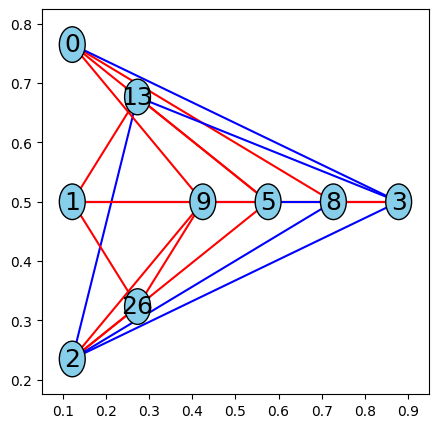

In [25]:
a = gen.population

input = [[0, 0,], [0, 1], [1, 0], [1, 1]]
output = [0, 1, 1, 0]
nn = a[-1].getNetwork()
res = [nn.calculate(i)[0] for i in input]
print(res)
nn.draw()
"""
for i in range(10):
    a[-1].mutate()
    a[-1].print()
    a[-1].getNetwork().draw()
G = a[-1].genes
G[(0, 4)].weight = 20
G[(1, 4)].weight = 20
G[(2, 4)].weight = -10
G[(0, 5)].weight = -20
G[(1, 5)].weight = -20
G[(2, 5)].weight = 30
G[(4, 3)].weight = 20
G[(5, 3)].weight = 20
G[(2, 3)].weight = -30
print(a[-1].testFitness())"""

In [24]:
gen.advanceGenerations(100)
print("here")
gen.testFitness()
a = gen.population
print(a[-1].fitness, a[-2].fitness, a[-1].speciationLikeness(a[-2]))
a[-1].print()
a[-2].print()

5 [30, 39, 31, 24, 29] [2.9999999997513864, 3.0, 3.0, 3.0, 2.99999999999994]
5 [27, 38, 34, 23, 30] [2.9999999997513864, 3.0, 3.0, 3.0, 2.999999999999994]
5 [30, 41, 36, 19, 27] [2.9999999997513864, 3.0, 3.0, 3.0, 2.9999999999999996]
5 [29, 35, 32, 28, 28] [2.9999999997513864, 3.0, 3.0, 3.0, 3.0]
5 [30, 32, 38, 26, 27] [2.9999999997513864, 3.0, 3.0, 3.0, 3.0]
34
5 [28, 29, 42, 25, 29] [2.999999999835186, 3.0, 3.0, 3.0, 3.0]
5 [32, 32, 32, 29, 28] [2.999999999835186, 3.0, 3.0, 3.0, 3.0]
5 [35, 22, 37, 30, 29] [2.999999999835186, 3.0, 3.0, 3.0, 3.0]
35
36
5 [28, 34, 37, 29, 24] [2.999999999835186, 3.0, 3.0, 3.0, 3.0]
5 [29, 36, 27, 33, 26] [2.999999999835186, 3.0, 3.0, 3.0, 3.0]
5 [31, 37, 23, 33, 28] [2.999999999835186, 3.0, 3.0, 3.0, 3.0]
5 [26, 38, 29, 35, 25] [2.999999999835186, 3.0, 3.0, 3.0, 3.0]
5 [29, 40, 27, 29, 27] [2.9999999998358198, 3.0, 3.0, 3.0, 3.0]
5 [24, 41, 34, 26, 27] [2.9999999998358198, 3.0, 3.0, 3.0, 3.0]
5 [30, 39, 32, 22, 30] [2.9999999998358198, 3.0, 3.0, 3.0, 3

In [11]:
print(NEATGenome.nodeNum)
for i in range(len(gen.population)):
    print(i)
    gen.population[i].print()
    gen.population[i].getNetwork()

39
0
0 {in: 0, out: 3, weight: 19.810386131003074, enabled: True}
1 {in: 1, out: 3, weight: 0.10955399337352026, enabled: True}
2 {in: 2, out: 3, weight: -9.816490199711657, enabled: True}
6 {in: 1, out: 5, weight: -2.776039687877469, enabled: True}
7 {in: 5, out: 3, weight: 18.920951061168413, enabled: True}
8 {in: 2, out: 5, weight: 0.9118116367085383, enabled: True}
3 {in: 0, out: 4, weight: -0.7684285328619788, enabled: True}
4 {in: 4, out: 3, weight: 0.5552079170962866, enabled: True}
5 {in: 2, out: 4, weight: 2.1024547020698656, enabled: True}
12 {in: 0, out: 5, weight: 1.9158705006591308, enabled: True}
1
0 {in: 0, out: 3, weight: 18.705331847848644, enabled: True}
1 {in: 1, out: 3, weight: 0.04514138753561997, enabled: False}
2 {in: 2, out: 3, weight: -10.148641229719523, enabled: True}
6 {in: 1, out: 5, weight: -3.1083604336300557, enabled: True}
7 {in: 5, out: 3, weight: 19.64184464860179, enabled: True}
8 {in: 2, out: 5, weight: 0.5399850233188929, enabled: True}
3 {in: 0, o

In [515]:
for i in range(len(gen.population)):
    print(i)
    for e in range(len(gen.population)):
        gen.population[i].cross(gen.population[e])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


In [178]:
ind = 0
while gen.population[-1].fitness < 3.5:
    print(gen.population[-1].fitness)
    print(ind)
    gen.nextGeneration()
    gen.testFitness()
    ind += 1

0.2727272727272727
0
[10, 10, 15, 9, 10, 11, 10, 15, 11, 15, 13, 15]
3.0
1
[13, 11, 14, 11, 13, 12, 14, 10, 7, 13, 12, 13]
3.0
2
[10, 9, 13, 9, 11, 14, 12, 14, 11, 16, 14, 13]
3.0
3
[11, 11, 13, 9, 11, 15, 10, 12, 10, 15, 15, 12]
3.0
4
[9, 11, 14, 9, 10, 15, 12, 14, 8, 16, 15, 13]
3.0
5
[13, 11, 13, 8, 13, 11, 11, 13, 9, 15, 13, 15, 1]
3.0
6
[9, 10, 16, 6, 9, 13, 10, 12, 11, 5, 10, 15]
3.0
7
[11, 9, 15, 11, 11, 12, 12, 14, 12, 12, 11, 11, 2]
3.0
8
[9, 10, 9, 7, 9, 11, 11, 13, 10, 12, 12, 11, 1]
3.0
9
[10, 8, 12, 8, 8, 11, 10, 13, 11, 11, 10, 14]
89
3.0
10
[11, 12, 13, 9, 10, 12, 10, 15, 12, 14, 12, 13, 1]
90
3.0
11
[9, 9, 14, 8, 7, 11, 10, 10, 10, 12, 13, 11, 2]
3.0
12
[10, 10, 12, 7, 7, 10, 9, 11, 12, 11, 11, 12, 2]
3.0
13
[11, 8, 10, 9, 7, 11, 12, 13, 11, 8, 13, 11, 2]
3.0
14
[9, 10, 13, 6, 8, 9, 10, 9, 12, 9, 15, 13]
3.0
15
[12, 13, 13, 11, 9, 13, 11, 15, 12, 10, 12, 13, 1]
3.0
16
[10, 11, 8, 8, 10, 11, 9, 11, 12, 9, 13, 12, 2]
3.0
17
[8, 12, 11, 8, 9, 11, 7, 12, 11, 10, 12, 12, 3]


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


3.0
54
[12, 9, 7, 10, 5, 9, 11, 19, 14, 8, 12, 2, 15]
3.0
55
[10, 9, 10, 10, 11, 9, 16, 11, 15, 7, 13, 4, 8]
3.0
56
[11, 9, 9, 9, 9, 9, 16, 11, 14, 14, 9, 11, 13]
3.0
57
[9, 11, 9, 11, 12, 13, 8, 10, 12, 14, 7, 12, 13, 1]
99
3.0
58
[10, 17, 8, 10, 12, 9, 9, 12, 11, 7, 10, 12, 1, 1, 1]
3.0
59
[7, 6, 8, 8, 8, 7, 8, 11, 9, 7, 10, 2, 10, 2, 2]
3.0
60
[9, 7, 10, 9, 11, 10, 7, 10, 8, 8, 9, 2, 9, 1]
3.0
61
[12, 8, 9, 9, 9, 8, 10, 10, 8, 10, 9, 2, 11, 2]


KeyboardInterrupt: 